# Imports

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# setting seed
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
(x_train, y_train), (x_val, y_val) = (x_train[:40000], y_train[:40000]), (x_train[40000:], y_train[40000:])
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

AUTO = tf.data.AUTOTUNE

169017344/169001437 [==============================] - 3s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


# Hyperparameters

In [3]:
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 100
BATCH_SIZE = 512

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

EPOCHS = 50

IMAGE_SIZE = 72  # We'll resize input images to this size
PATCH_SIZE = 6  # Size of the patches to be extract from the input images
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]  # Size of the transformer layers
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = (
    val_ds
    .shuffle(1024)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = (
    test_ds
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Data Augmentation

In [15]:
def get_augmentation_model():
    model = keras.Sequential([
        layers.InputLayer(INPUT_SHAPE),
        layers.Rescaling(1/255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        )],
        name="data_augmentation")
    return model

In [16]:
images = tf.constant(x_train[0:2])
augmentation_model = get_augmentation_model()

augmeneted_images = augmentation_model(images)
augmeneted_images.shape

TensorShape([2, 72, 72, 3])

# Create Patches

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        # assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3)
        self.resize = layers.Reshape((-1, patch_size*patch_size*3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

In [57]:
images = tf.constant(x_train[0:1])
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(images)

patches = Patches(patch_size=PATCH_SIZE)(augmeneted_images)
patches.shape

TensorShape([1, 144, 108])

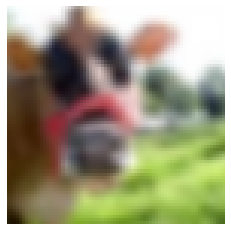

In [58]:
plt.figure(figsize=(4, 4))
plt.imshow(keras.utils.array_to_img(augmeneted_images[0]))
plt.axis("off")
plt.show()

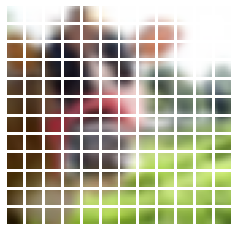

In [59]:
n = 12
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(keras.utils.img_to_array(patch_img))
    plt.axis("off")
plt.show()

In [60]:
num_mask = int(0.75 * 144)

rand_indices = tf.argsort(tf.random.uniform((1, 144)), axis=-1)
mask_indices, unmask_indices = rand_indices[:, :num_mask], rand_indices[:, num_mask:]

unmasked_patches = tf.gather(patches, unmask_indices, axis=1, batch_dims=1)
masked_patches = tf.gather(patches, mask_indices, axis=1, batch_dims=1)

In [61]:
ids = tf.argsort(unmask_indices)
unmask_indices = tf.sort(unmask_indices)
unmasked_patches = tf.gather(unmasked_patches, ids, batch_dims=1)

print(unmasked_patches.shape)
print(unmask_indices.shape)

(1, 36, 108)
(1, 36)


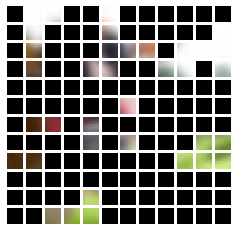

In [64]:
n = 12
unmask_index = unmask_indices[0]
unmasked_patch = unmasked_patches[0]

plt.figure(figsize=(4, 4))

count = 0
for i in range(144):
    ax = plt.subplot(n, n, i + 1)

    if count<36 and unmask_index[count].numpy() == i:
        patch = unmasked_patch[count]
        patch_img = tf.reshape(patch, (6, 6, 3))
        plt.imshow(keras.utils.img_to_array(patch_img))
        plt.axis("off")
        count = count+1
    else:
        patch_img = tf.zeros((6, 6, 3))
        plt.imshow(keras.utils.img_to_array(patch_img))
        plt.axis("off")
plt.show()

# Models

In [23]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, projection_dim, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection_dim = projection_dim # 64
        self.batch_size = batch_size
        self.mask_token = tf.Variable(
            tf.random.normal(
                [1, patch_size*patch_size*3]
            ))

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # create the projection layer
        self.projection = layers.Dense(units=self.projection_dim)
        
        # create the positional embedding layer
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim)
        
        # 75% of number of patches should be masked
        self.num_mask = int(0.75 * self.num_patches)

        # create random indices from a uniform distribution and then split
        # it into mask and unmask indices
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(self.batch_size, self.num_patches)),
            axis=-1)
        self.mask_indices = rand_indices[:, :self.num_mask]
        self.unmask_indices = rand_indices[:, self.num_mask:]

    def call(self, patch):
        # patch shape = (B, num_patches, p*p*3)
        # get the positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(pos_embeddings, [self.batch_size, 1, 1]) # (B, num_patches, projection_dim)

        # embedd the patches
        patch_embeddings = self.projection(patch) + pos_embeddings # (B, num_patches, projection_dim)

        # the encoder input is the unmasked patch embeddings
        unmasked_embeddings = tf.gather(
            patch_embeddings,
            self.unmask_indices,
            axis=1,
            batch_dims=1) # (B, unmask_numbers, projection_dim)

        # get the unmasked and masked positions
        unmasked_positions = tf.gather(
            pos_embeddings,
            self.unmask_indices,
            axis=1,
            batch_dims=1) # (B, unmask_numbers, projection_dim)
        masked_positions = tf.gather(
            pos_embeddings,
            self.mask_indices,
            axis=1,
            batch_dims=1) # (B, mask_numbers, projection_dim)

        mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
        mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...],
                repeats=self.batch_size,
                axis=0)

        # get the masked embeddings
        masked_embeddings = self.projection(mask_tokens) + masked_positions

        return unmasked_embeddings, masked_embeddings, unmasked_positions

In [10]:
images = tf.random.normal((2, 32, 32, 3))
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(images)

patches = Patches(patch_size=PATCH_SIZE)(augmeneted_images)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=2)
unmasked_embeddings, masked_embeddings, unmasked_positions = patch_encoder(patches)

unmasked_embeddings.shape, masked_embeddings.shape, unmasked_positions.shape

(TensorShape([2, 36, 64]), TensorShape([2, 108, 64]), TensorShape([2, 36, 64]))

In [36]:
def get_mlp(hidden_units, dropout_rate):
    layers_list = []
    for units in hidden_units:
        layers_list.append(layers.Dense(units, activation=tf.nn.gelu))
        layers_list.append(layers.Dropout(dropout_rate))
    
    model = keras.Sequential(layers_list)
    return model

In [51]:
class Encoder(layers.Layer):
    def __init__(self, num_layers, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.add1 = layers.Add()
        self.add2 = layers.Add()

        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

    def build(self, input_shape):
        (_, self.num_unmask, self.projection_dim) = input_shape
        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim//self.num_heads,
            dropout=0.1
        )
    
    def call(self, inputs):
        for _ in range(self.num_layers):
            # Layer normalization 1.
            x1 = self.layer_norm1(inputs)
            # Create a multi-head attention layer.
            attention_output = self.mha1(query=x1, value=x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, inputs])
            # Layer normalization 2.
            x3 = self.layer_norm2(x2)
            # MLP.
            x3 = self.mlp(x3)
            # Skip connection 2.
            inputs = self.add2([x3, x2])

        # Create the encoder ouputs
        encoder_outputs = self.layer_norm3(inputs)
        
        return encoder_outputs

In [52]:
images = tf.random.normal((2, 32, 32, 3))
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(images)

patches = Patches(patch_size=PATCH_SIZE)(augmeneted_images)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=2)
unmasked_embeddings, masked_embeddings, unmasked_positions = patch_encoder(patches)

encoder = Encoder(num_layers=2, num_heads=2)
encoder_outputs = encoder(unmasked_embeddings)
encoder_outputs.shape

TensorShape([2, 36, 64])

In [53]:
class Decoder(layers.Layer):
    def __init__(self, num_layers, num_heads, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.patch_size = patch_size
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.mlp = get_mlp(hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)

    def build(self, input_shape):
        (_, self.num_patches, self.projection_dim) = input_shape
        self.mha1 = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.projection_dim//self.num_heads,
            dropout=0.1)
        self.dense = layers.Dense(
            units=self.patch_size*self.patch_size*3,
            activation="sigmoid")
    
    def call(self, inputs):
        for _ in range(self.num_layers):
            # Layer normalization 1.
            x1 = self.layer_norm1(inputs)
            # Create a multi-head attention layer.
            attention_output = self.mha1(query=x1, value=x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, inputs])
            # Layer normalization 2.
            x3 = self.layer_norm2(x2)
            # MLP.
            x3 = self.mlp(x3)
            # Skip connection 2.
            inputs = self.add1([x3, x2])

        # Create the encoder ouputs
        decoder_outputs = self.layer_norm3(inputs)
        decoder_outputs = self.dense(decoder_outputs)
        return decoder_outputs

In [54]:
images = tf.random.normal((2, 32, 32, 3))
augmentation_model = get_augmentation_model()
augmeneted_images = augmentation_model(images)

patches = Patches(patch_size=PATCH_SIZE)(augmeneted_images)
print(patches.shape)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=2)
unmasked_embeddings, masked_embeddings, unmasked_positions = patch_encoder(patches)

encoder = Encoder(num_layers=2, num_heads=2)
encoder_outputs = encoder(unmasked_embeddings)
encoder_outputs = encoder_outputs + unmasked_positions
decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

decoder = Decoder(num_layers=2, num_heads=2, patch_size=PATCH_SIZE)
decoder_outputs = decoder(decoder_inputs)

print(decoder_outputs.shape)

(2, 144, 108)
(2, 144, 108)


In [55]:
class MaskedAutoencoder(keras.Model):
    def __init__(self, augmentation_model, patch_layer, patch_encoder, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.augmentation_model = augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
    
    def compile(self, optimizer, loss, run_eagerly=False):
        super().compile(run_eagerly=run_eagerly)
        self.optimizer = optimizer
        self.loss = loss
    
    def train_step(self, images):
        with tf.GradientTape() as tape:
            augmeneted_images = self.augmentation_model(images)
            patches = self.patch_layer(augmeneted_images)
            (unmasked_embeddings, masked_embeddings, unmasked_positions) = self.patch_encoder(patches)
            encoder_outputs = self.encoder(unmasked_embeddings)
            encoder_outputs = encoder_outputs + unmasked_positions
            decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
            decoder_outputs = self.decoder(decoder_inputs)
            total_loss = self.loss(patches, decoder_outputs)
        train_vars = [
            self.augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g,v))
        self.optimizer.apply_gradients(tv_list)
    
        return {"loss": total_loss}
    
    def test_step(self, images):
        augmeneted_images = self.augmentation_model(images)
        patches = self.patch_layer(augmeneted_images)
        (unmasked_embeddings, masked_embeddings, unmasked_positions) = self.patch_encoder(patches)
        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        total_loss = self.loss(patches, decoder_outputs)    
        return {"loss": total_loss}

In [56]:
! pip install -q tensorflow-addons
import tensorflow_addons as tfa

In [57]:
keras.backend.clear_session()

augmentation_model = get_augmentation_model()
patch_layer = Patches(patch_size=PATCH_SIZE)
patch_encoder = PatchEncoder(patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM, batch_size=BATCH_SIZE)
encoder = Encoder(num_layers=TRANSFORMER_LAYERS, num_heads=NUM_HEADS)
decoder = Decoder(num_layers=TRANSFORMER_LAYERS, num_heads=NUM_HEADS, patch_size=PATCH_SIZE)

mae = MaskedAutoencoder(
    augmentation_model=augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder)

optimizer = tfa.optimizers.AdamW(
    learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

mae.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
)

In [ ]:
history = mae.fit(
    train_ds,
    steps_per_epoch=100,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=100)

Epoch 1/50
100/100 [==============================] - 54s 454ms/step - loss: 0.8503 - val_loss: 0.7441
Epoch 2/50
100/100 [==============================] - 44s 438ms/step - loss: 0.7465 - val_loss: 0.7513
Epoch 3/50
100/100 [==============================] - 44s 438ms/step - loss: 0.7247 - val_loss: 0.7311
Epoch 4/50
100/100 [==============================] - 44s 438ms/step - loss: 0.7192 - val_loss: 0.7513
Epoch 5/50
100/100 [==============================] - 44s 438ms/step - loss: 0.7184 - val_loss: 0.6999
Epoch 6/50
100/100 [==============================] - 44s 438ms/step - loss: 0.7150 - val_loss: 0.7168
Epoch 7/50
100/100 [==============================] - 44s 439ms/step - loss: 0.7122 - val_loss: 0.7370
Epoch 8/50
100/100 [==============================] - 44s 437ms/step - loss: 0.7136 - val_loss: 0.7150
Epoch 9/50
100/100 [==============================] - ETA: 0s - loss: 0.7142

In [ ]:
loss = mae.evaluate(test_ds)
print(loss)